In [17]:
import numpy as np
np.geomspace(0.0001, 0.01, num=10, endpoint=True)
print(x)

[3.16227766e-06 2.37137371e-07 1.77827941e-08 1.33352143e-09
 1.00000000e-10]


Graph loaded with 1500 nodes and 6600 edges
   ✓ Encoded 'attribute': ['d', 'f', 'l', 'm', 'x', 'y']

=== Fold 1 ===

2.1 Pre-computing graph metrics...
   ✓ Metrics computed
Fold 1 AUC: 0.9195 Validation Accuracy: 0.8803

=== Fold 2 ===

2.2 Pre-computing graph metrics...
   ✓ Metrics computed
Fold 2 AUC: 0.9289 Validation Accuracy: 0.8788

=== Fold 3 ===

2.3 Pre-computing graph metrics...
   ✓ Metrics computed
Fold 3 AUC: 0.9280 Validation Accuracy: 0.8833

=== Fold 4 ===

2.4 Pre-computing graph metrics...
   ✓ Metrics computed
Fold 4 AUC: 0.9261 Validation Accuracy: 0.8811

=== Fold 5 ===

2.5 Pre-computing graph metrics...
   ✓ Metrics computed
Fold 5 AUC: 0.9275 Validation Accuracy: 0.8833


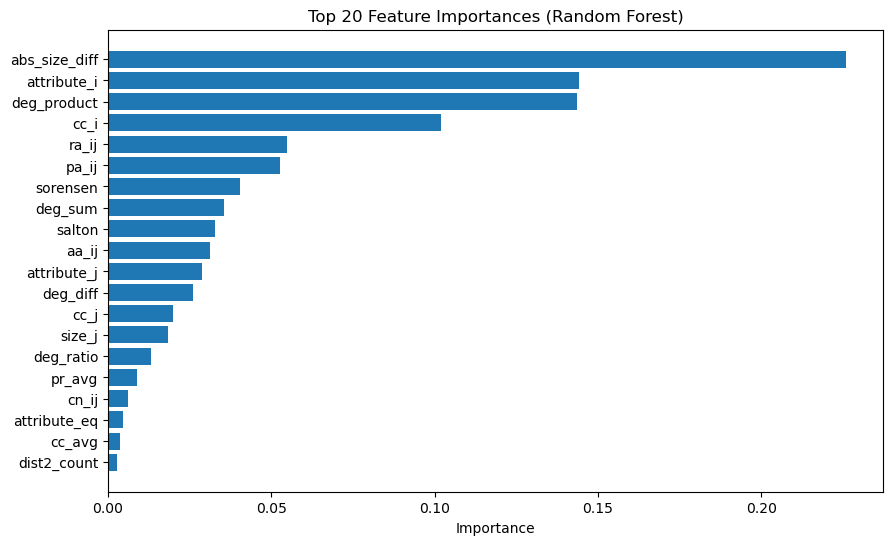

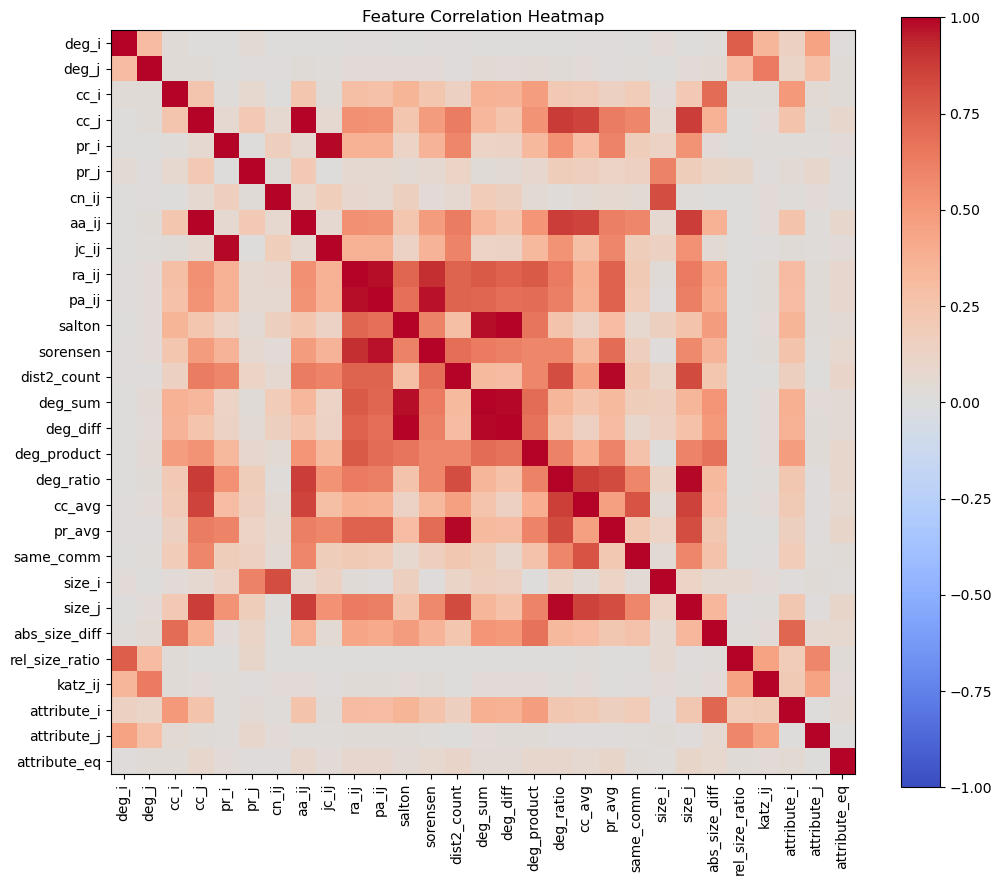


Mean AUC: 0.9260 ± 0.0034

Mean Acc: 0.8814 ± 0.0018


In [38]:
# ===== Imports =====
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Define random seed
seed = 42

# Use features:
comm = True
use_katz = True

commsizeacc = {}

# resolutions = np.arange(0.005, 0.051, 0.005).round(3).tolist()

# for res in resolutions:
    
# ===== Load & visualize graph =====
path = "./../assignment2_files_2025/edges_train.edgelist"
G = nx.read_edgelist(path, delimiter=',', nodetype=int, create_using=nx.Graph())

print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

#pos = nx.spring_layout(G, seed=42)
#nx.draw(G, pos=pos, node_size=20, with_labels=False)
#plt.show()

# Attributes
pathattributes = "./../assignment2_files_2025/attributes.csv"
attributes_df = pd.read_csv(pathattributes)
node_id_col = attributes_df.columns[0]
attribute_cols = [col for col in attributes_df.columns if col != node_id_col]

# Encode categorisch naar numeriek
for col in attribute_cols:
    if attributes_df[col].dtype == 'object':
        le = LabelEncoder()
        attributes_df[col] = le.fit_transform(attributes_df[col].astype(str))
        print(f"   ✓ Encoded '{col}': {list(le.classes_)}")
attributes_dict = attributes_df.set_index(node_id_col).to_dict('index')

# # ===== (optioneel) edges ongewijzigd wegschrijven =====
# edges = list(G.edges())
# pd.DataFrame(edges).to_csv("edges_train.edgelist", index=False, header=False)

# ===== Feature engineering =====
def get_features(G, i, j):
    """
    Features voor node pair (i, j)
    Totaal: 4 attribute + 20 graph features = 24 features
    """
    features = []

    attrs_i = attributes_dict.get(i, {})
    attrs_j = attributes_dict.get(j, {})

    for col in attribute_cols:
        val_i = attrs_i.get(col, 0)
        val_j = attrs_j.get(col, 0)
        features.append(val_i)
        features.append(val_j)
        #features.append(int(val_i != val_j))        # verschil
        features.append(int(val_i == val_j))

    # --- Basic node features (6) ---
    deg_i = G.degree(i)
    deg_j = G.degree(j)
    cc_i = clustering.get(i, 0)
    cc_j = clustering.get(j, 0)
    pr_i = pagerank.get(i, 0)
    pr_j = pagerank.get(j, 0)

    # --- Neighborhood features (7) ---
    common = list(nx.common_neighbors(G, i, j))
    cn_ij = len(common)

    neigh_i = set(G.neighbors(i))
    neigh_j = set(G.neighbors(j))
    union_sz = len(neigh_i | neigh_j)
    
    # Jaccard
    jc_ij = next(nx.jaccard_coefficient(G, [(i,j)]))[2]
    
    # Adamic-Adar
    aa_ij = sum(1.0 / np.log(G.degree(z)) for z in common if G.degree(z) > 1)

    # Resource Allocation
    ra_ij = sum(1.0 / G.degree(z) for z in common if G.degree(z) > 0)
    
    # Preferential Attachment
    pa_ij = pa[i, j]

    # Salton
    salton = cn_ij / np.sqrt(deg_i * deg_j) if (deg_i * deg_j) > 0 else 0
    
    # Sorensen
    sorensen = (2 * cn_ij) / (deg_i + deg_j) if (deg_i + deg_j) > 0 else 0

    #Katz:
    katz_ij = katz_matrix[i, j]

    # 2 hop neighbors
    # nodes reachable within 2 hops from i
    dist2_i = set(nx.single_source_shortest_path_length(G, i, cutoff=2))
    # nodes reachable within 2 hops from j
    dist2_j = set(nx.single_source_shortest_path_length(G, j, cutoff=2))
    
    # remove the nodes themselves and their direct neighbors
    dist2_i -= {i} | set(G.neighbors(i))
    dist2_j -= {j} | set(G.neighbors(j))
    
    # intersection of these “exactly distance-2” neighborhoods
    dist2_count = len(dist2_i & dist2_j)

    # --- Derived features (6) ---
    deg_sum = deg_i + deg_j
    deg_diff = abs(deg_i - deg_j)
    deg_product = deg_i * deg_j
    deg_ratio = min(deg_i, deg_j) / max(deg_i, deg_j) if max(deg_i, deg_j) > 0 else 0
    cc_avg = (cc_i + cc_j) / 2
    pr_avg = (pr_i + pr_j) / 2

    # --- Communties ---
    # --- Community features ---
    comm_i = community_dict.get(i, -1)
    comm_j = community_dict.get(j, -1)
    
    # Same community indicator
    same_comm = int(comm_i == comm_j)
    # Comm size
    size_i = comm_sizes.get(comm_i, 0)
    size_j = comm_sizes.get(comm_j, 0)
    # Abs comm size diff
    abs_size_diff = abs(size_i - size_j)
    # Relative comm size diff
    if size_i + size_j > 0:
        rel_size_ratio = size_i / (size_j + 1e-6)
    else:
        rel_size_ratio = 0

    # Combine all features
    features.extend([
        deg_i, deg_j, cc_i, cc_j, pr_i, pr_j,
        cn_ij, aa_ij, jc_ij, ra_ij, pa_ij, salton, sorensen,
        dist2_count,
        deg_sum, deg_diff, deg_product, deg_ratio, cc_avg, pr_avg, same_comm, 
    size_i, size_j, 
    abs_size_diff, 
    rel_size_ratio,
    katz_ij
    ])
    

    return np.array(features, dtype=float)


# ===== Kfold splitting for testing =====
edges = np.array(list(G.edges()))
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
auc_scores = []
acc_scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(edges), 1):
    print(f"\n=== Fold {fold} ===")

    # Split edges
    train_edges = edges[train_idx]
    val_edges   = edges[val_idx]

    # Build training graph
    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)

    # ===== PRE-COMPUTE METRICS =====
    print(f"\n2.{fold} Pre-computing graph metrics...")
    
    N = G_train.number_of_nodes()
    
    # Preferential Attachment
    pa = np.zeros((N, N))
    for u, v, p in nx.preferential_attachment(G_train, [(i, j) for i in range(N) for j in range(N)]):
        pa[u, v] = p
    
    # PageRank
    pagerank = nx.pagerank(G_train)
    
    # Clustering        
    clustering = nx.clustering(G_train)

    # Communities
    communities = list(nx.algorithms.community.greedy_modularity_communities(G_train, resolution=1))
    community_dict = {n: cid for cid, nodes in enumerate(communities) for n in nodes}
    comm_sizes = {cid: len(nodes) for cid, nodes in enumerate(communities)}
    print("   ✓ Metrics computed")

    # Katz
    # Create adjacency matrix
    A = nx.to_numpy_array(G_train)
    beta = 0.01
    I = np.eye(A.shape[0])
    
    # Katz matrix: (I - beta*A)^-1 - I
    katz_matrix = np.linalg.inv(I - beta * A) - I

    # Normalize
    katz_values = katz_matrix.flatten().reshape(-1, 1)
    katz_matrix = MinMaxScaler().fit_transform(katz_values).reshape(A.shape)

    # Build training data
    pos_train = train_edges
    rng = np.random.default_rng(seed)
    non_edges = np.array(list(nx.non_edges(G_train)))
    neg_train = non_edges[rng.choice(len(non_edges), size=len(pos_train), replace=False)]
    X_train = [get_features(G_train, u, v) for (u,v) in np.vstack([pos_train, neg_train])]
    y_train = [1]*len(pos_train) + [0]*len(neg_train)

    # Build validation data (features from G_train!)
    pos_val = val_edges
    rng2 = np.random.default_rng(seed+1)
    non_edges = np.array(list(nx.non_edges(G_train)))
    neg_val = non_edges[rng2.choice(len(non_edges), size=len(pos_val), replace=False)]
    X_val = [get_features(G_train, u, v) for (u,v) in np.vstack([pos_val, neg_val])]
    y_val = [1]*len(pos_val) + [0]*len(neg_val)

    # Train + evaluate
    # Model configuratie
    clf = RandomForestClassifier(
        n_estimators=100,       # Aantal trees
        max_depth=2,           # Minder diep (was 12)
        min_samples_split=10,   # Meer samples nodig (was 8)
        min_samples_leaf=1,     # Grotere leafs (was 4)
        max_features='sqrt',   # Features per split
        bootstrap = True,
        random_state=42,
        n_jobs=-1              # Gebruik alle CPU cores
    )


    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)
    
    # Predict on validation set
    y_pred_val = clf.predict(X_val)  # use .predict, not .predict_proba
    
    # Compute accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    acc_scores.append(val_acc)
    
    print(f"Fold {fold} AUC: {auc:.4f} Validation Accuracy: {val_acc:.4f}")

    importances = clf.feature_importances_

# Get feature names
attribute_pairs = [f"{col}_i" for col in attribute_cols] + [f"{col}_j" for col in attribute_cols] + [f"{col}_eq" for col in attribute_cols]

graph_features = [
    'deg_i','deg_j','cc_i','cc_j','pr_i','pr_j',
    'cn_ij','aa_ij','jc_ij','ra_ij','pa_ij','salton','sorensen',
    'dist2_count',
    'deg_sum','deg_diff','deg_product','deg_ratio','cc_avg','pr_avg', 'same_comm', 
    'size_i', 'size_j', 
    'abs_size_diff', 
    'rel_size_ratio',
    'katz_ij'
]
feature_names = graph_features + attribute_pairs
# Rank features
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_df['Feature'][:20][::-1], feat_df['Importance'][:20][::-1])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

X = np.array([get_features(G, u, v) for (u,v) in np.vstack([pos_train, neg_train])])
corr = abs(pd.DataFrame(X, columns=feature_names).corr())
plt.figure(figsize=(12,10))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.colorbar()
plt.title("Feature Correlation Heatmap")
plt.show()



print(f"\nMean AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"\nMean Acc: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")

# commsizeacc[res] = np.mean(acc_scores)

In [37]:
corr['deg_product'].sort_values()

rel_size_ratio    0.005659
deg_i             0.005666
size_i            0.005862
attribute_j       0.025938
katz_ij           0.033651
deg_j             0.043836
cn_ij             0.050169
pr_j              0.078629
attribute_eq      0.089508
same_comm         0.258149
jc_ij             0.322437
pr_i              0.326198
cc_avg            0.386316
attribute_i       0.470577
cc_i              0.475681
aa_ij             0.519403
cc_j              0.525135
dist2_count       0.588047
sorensen          0.590087
pr_avg            0.594274
size_j            0.595778
deg_ratio         0.601955
salton            0.661018
abs_size_diff     0.676330
deg_diff          0.678391
deg_sum           0.696834
pa_ij             0.701483
ra_ij             0.773372
deg_product       1.000000
Name: deg_product, dtype: float64

{0.5: np.float64(0.8094696969696971), 0.6: np.float64(0.8074242424242424), 0.7: np.float64(0.8071969696969697), 0.8: np.float64(0.8127272727272727), 0.9: np.float64(0.8247727272727271), 1.0: np.float64(0.8253787878787877), 1.1: np.float64(0.8206060606060606), 1.2: np.float64(0.8204545454545455), 1.3: np.float64(0.8188636363636365), 1.4: np.float64(0.8188636363636365), 1.5: np.float64(0.8188636363636365)}


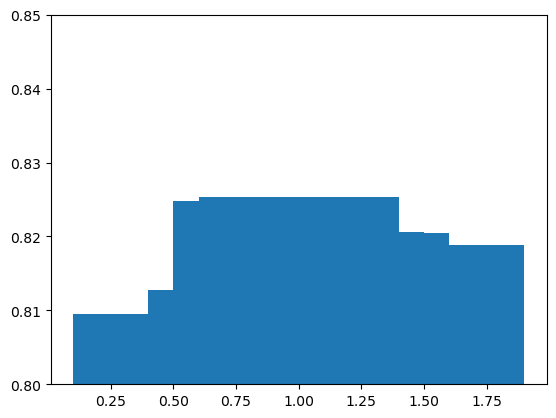

In [46]:
print(commsizeacc)
fig, ax = plt.subplots()  # Correct way to create a figure and axes
ax.bar(commsizeacc.keys(), commsizeacc.values())
ax.set_ylim(0.80, 0.85)    # Set y-axis limits
plt.show()

In [69]:
# ===== Kaggle submission (exact: ID,prediction) =====
# Verwacht: solutionInput.csv met kolommen: ID, u, v  (ID = index)
inpTest = pd.read_csv('./../assignment2_files_2025/solutionInput.csv', sep=',', index_col='ID')

# Features voor elk (u,v)-paar
inp = np.array([get_features(G, int(row[0]), int(row[1])) for _, row in inpTest.iterrows()])

# Voorspellingen (0/1) met SVM
predictionsManyFeatLowDepth = clf.predict(inp)

# Schrijf in exact Kaggle-formaat: ID,prediction (zonder indexkolom)
sub = pd.DataFrame({'ID': inpTest.index, 'prediction': predictionsManyFeatLowDepth})
sub.to_csv('predictionsManyFeatLowDepth.csv', index=False)

print("✅ Klaar: predictionsManyFeatLowDepth.csv aangemaakt in Kaggle-formaat (ID,prediction).")

C:\Users\schud\AppData\Local\Temp\ipykernel_1588\3527733878.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inp = np.array([get_features(G, int(row[0]), int(row[1])) for _, row in inpTest.iterrows()])


✅ Klaar: predictionsManyFeatLowDepth.csv aangemaakt in Kaggle-formaat (ID,prediction).
